# Propuesta "*Fourier coarse to fine CNN Model*"
## Alumno: Patrick Xavier Marquez Choque
## Curso: Proyecto Final de Carrera II
## Periodo: 2023-I

In [ ]:
######
#@title 1. Instalar Miniconda
######
%%capture
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-latest-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
######
#@title 2. Clonar Repositorio
######
%%capture
%%bash
rm -rf FcF-Inpainting/
git clone https://github.com/SHI-Labs/FcF-Inpainting
cd FcF-Inpainting/
pwd

In [ ]:
######
#@title 3. Crear el Entorno en Conda
######
%%capture
%%bash
conda init bash
conda env remove -n fcf
conda create --name fcf -y python=3.7

In [ ]:
######
#@title 4. Instalar Librerías y Dependencias
######
%%capture
%%bash
source activate fcf
conda env list
conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cudatoolkit=11.0 -c pytorch
cd /content/FcF-Inpainting/
pip3 install -r requirements.txt --quiet
pip3 uninstall opencv-python-headless -y --quiet
pip3 install opencv-python-headless --quiet

In [ ]:
######
#@title 5. Etapa de Enmascaramiento de los Datos
######

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import shutil

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [ ]:
######
#@title 6. Descargar el Dataset de Places2
######
%%bash
cd /content/FcF-Inpainting/
wget https://shi-labs.com/projects/fcf-inpainting/places_512.pkl

--2023-07-12 00:25:30--  https://shi-labs.com/projects/fcf-inpainting/places_512.pkl
Resolving shi-labs.com (shi-labs.com)... 128.223.4.25
Connecting to shi-labs.com (shi-labs.com)|128.223.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 802650681 (765M) [application/octet-stream]
Saving to: ‘places_512.pkl’

     0K .......... .......... .......... .......... ..........  0%  309K 42m17s
    50K .......... .......... .......... .......... ..........  0%  619K 31m41s
   100K .......... .......... .......... .......... ..........  0% 89.5M 21m10s
   150K .......... .......... .......... .......... ..........  0% 98.8M 15m55s
   200K .......... .......... .......... .......... ..........  0%  623K 16m55s
   250K .......... .......... .......... .......... ..........  0% 46.6M 14m9s
   300K .......... .......... .......... .......... ..........  0% 69.0M 12m9s
   350K .......... .......... .......... .......... ..........  0%  169M 10m38s
   400K .......... ..

# Etapa de Pruebas


In [ ]:
######
#@title 7. Cargar las imágenes (512x512)
######
from google.colab import files
files = files.upload()
fnames = list(files.keys())

shutil.rmtree('./colab_data', ignore_errors=True)
! mkdir colab_data

for fn in fnames:
  copyfile(fn, f'./colab_data/{fn}')
  os.remove(fn)

Saving pintura.png to pintura.png


Will use ./colab_data/pintura.png for inpainting


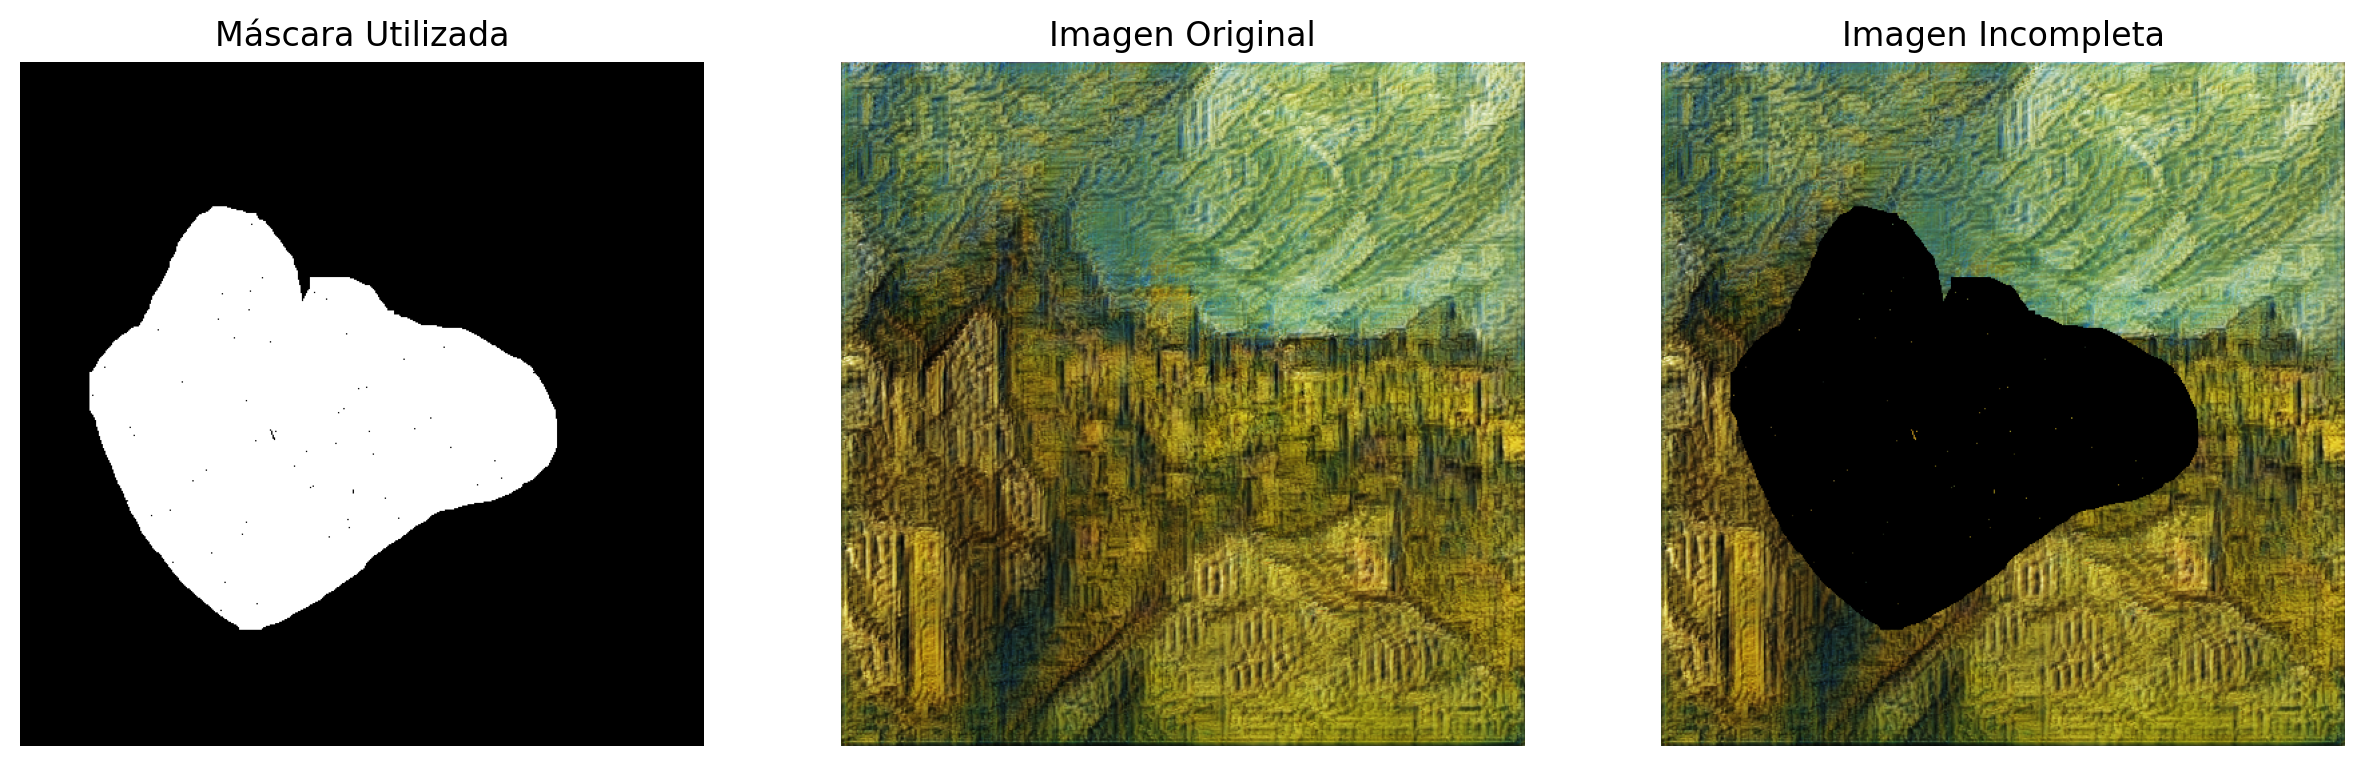

In [ ]:
#@title 8. Dibujar la máscara
################
fname=f'./colab_data/{fnames[0]}'
################
image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Máscara Utilizada')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('Imagen Original')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('Imagen Incompleta')
plt.show()

### 9. Reconstrucción Visual de la Prueba

In [ ]:
%%bash
################
export fname=pintura.png
################
cd /content/FcF-Inpainting/
source activate fcf
pip3 install -r requirements.txt --quiet
python colab_demo.py --img_path ../colab_data/$fname --output ../outputs --ckpt places_512.pkl
echo "Saved results to outputs/..."

Loading networks from "places_512.pkl"...
Generator Params: 85.086823 M
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Saved results to outputs/...


### 10. Plotear los Resultados

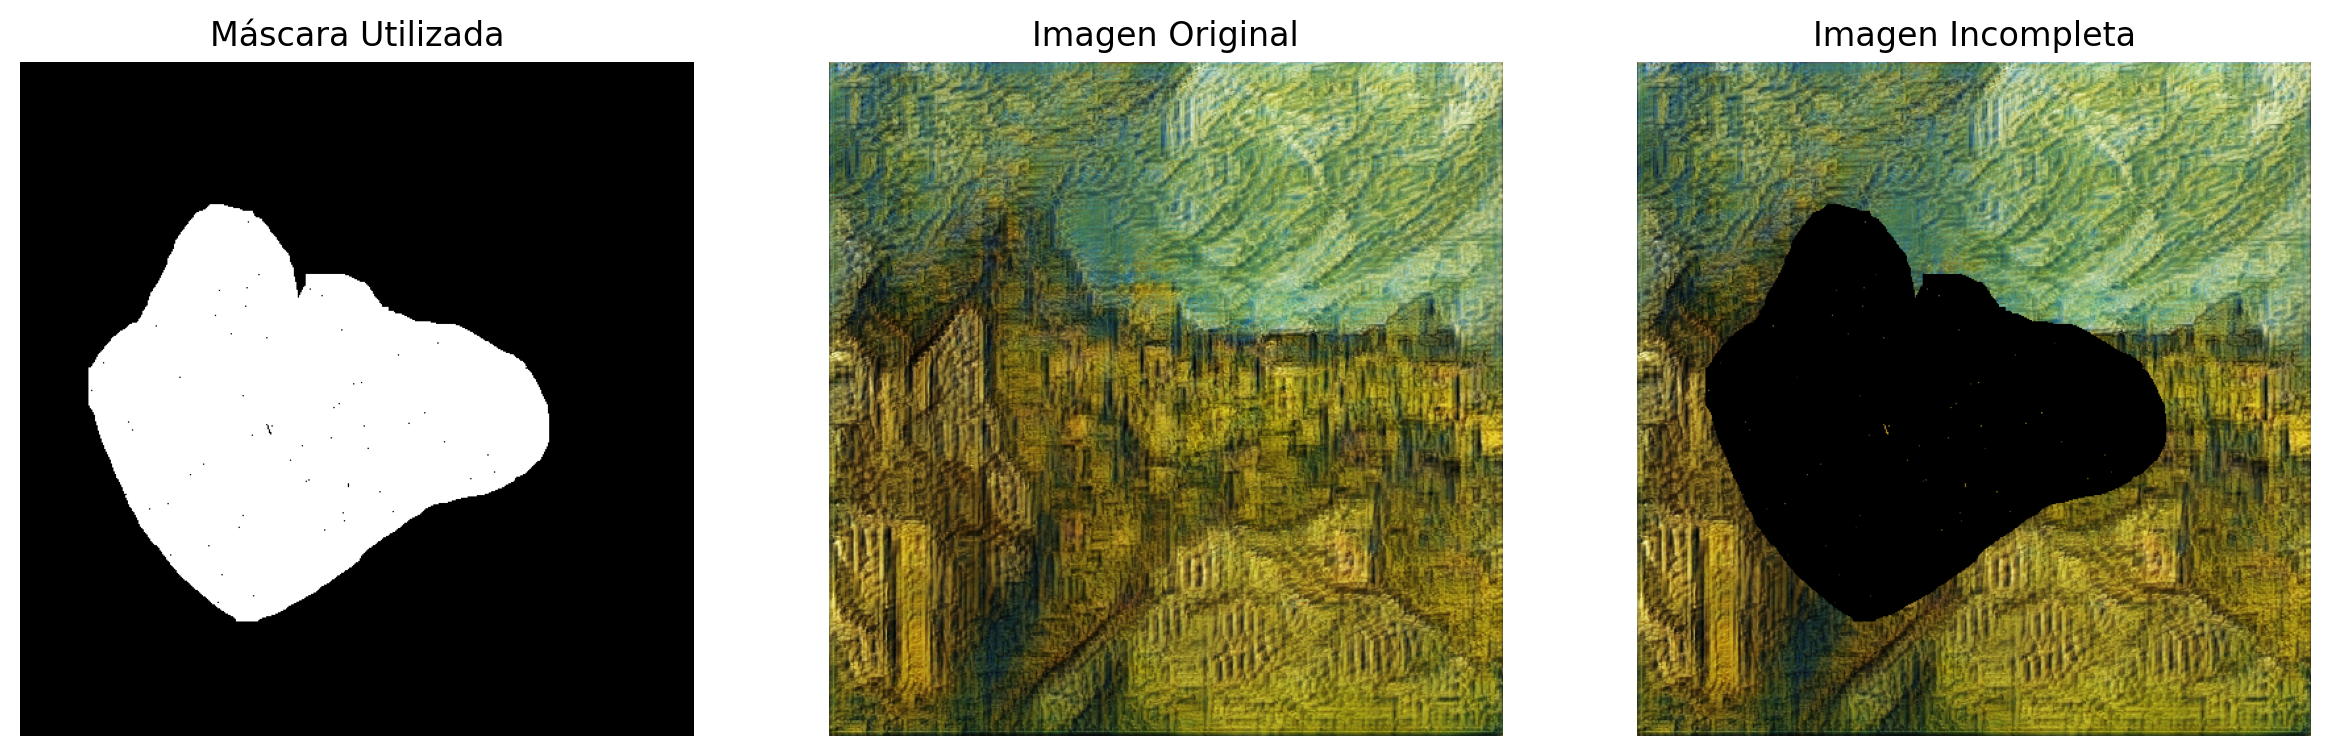

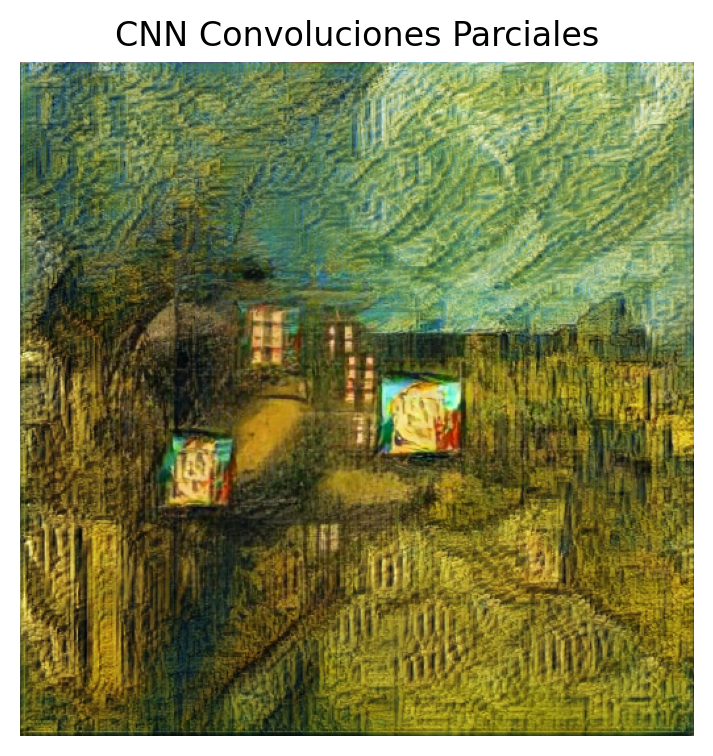

In [ ]:
################
fname=f'./colab_data/{fnames[0]}'
iname=fname.split('/')[-1]  ## Write filename here
################
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(141)
mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Máscara Utilizada')

plt.subplot(142)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('Imagen Original')

plt.subplot(143)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('Imagen Incompleta')
plt.show()

plt.subplot(144)
comp_img = np.array(plt.imread(f"outputs/{iname}")[:,:,:3])
plt.imshow(comp_img)
_=plt.axis('off')
_=plt.title('Modelo FcF')


# Etapa de Métricas PSNR y SSIM

In [ ]:
#@title 11a. Primera métrica de evaluación: PSNR (Proporción Máxima de Señal a Ruido)

from math import log10, sqrt
import cv2
import numpy as np

def calculate_psnr(img, comp_img):
    # Obtener las dimensiones de las imágenes
    height, width = img.shape[:2]

    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((img - comp_img) ** 2)

    # Calcular el rango máximo de los píxeles
    max_pixel = 255.0

    # Calcular el PSNR utilizando la fórmula
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

# Definir arreglos de los valores de las métricas
psnr_values = []
ssim_values = []

# Cargar las imágenes
img = cv2.imread("/content/colab_data/pintura.png")
comp_img = cv2.imread("/content/outputs/pintura.png")

# Convertir las imágenes a tipo float32
img = img.astype(np.float32)
comp_img = comp_img.astype(np.float32)

# Calcular el PSNR
psnr_value = calculate_psnr(img, comp_img)

# Imprimir el resultado
print("PSNR:", psnr_value)


PSNR: 20.83804144094205


In [ ]:
#@title 11b. Score PSNR del experimento
psnr_values.append(psnr_value)

In [ ]:
#@title 11c. Lista de Valores PSNR de todos los experimentos

def print_values():
  print("VALORES PSNR")
  for x in psnr_values:
    print(x)

print_values()

VALORES PSNR
18.87537114110642
20.83804144094205


In [ ]:
#@title 11d. Score PSNR Promedio

def calcular_promedio(arr):
    total = sum(arr)
    promedio = total / len(arr)
    return promedio

promedio = calcular_promedio(psnr_values)
print("Promedio de PSNR:", promedio)

Promedio de PSNR: 19.856706291024235


In [ ]:
#@title 11e. Segunda Métrica de Evaluación: SSIM (Índice de similitud estructural)

from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img, comp_img):
    # Asegurarse de que las imágenes estén en el rango correcto
    img = img.astype(np.uint8)
    comp_img = comp_img.astype(np.uint8)

    # Calcular el SSIM entre las imágenes
    ssim_score = ssim(img, comp_img, channel_axis=2)

    return ssim_score

# Convertir las imágenes a tipo float32
img = img.astype(np.float32)
comp_img = comp_img.astype(np.float32)

# Calcular el SSIM
ssim_value = calculate_ssim(img, comp_img)

# Imprimir el valor del SSIM
print("Valor del SSIM:", ssim_value)
print("Valor del SSIM porcentaje:", ssim_value*100,"%")

Valor del SSIM: 0.7728707200435864
Valor del SSIM porcentaje: 77.28707200435863 %


In [ ]:
#@title 11f. Score SSIM del experimento

ssim_values.append(ssim_value)

In [ ]:
#@title 11e. Lista de Valores SSIM de todos los experimentos

def print_ssim_values():
  print("VALORES PSNR")
  for x in ssim_values:
    print(x)

print_ssim_values()

VALORES PSNR
0.5054355994943411
0.7728707200435864


In [ ]:
#@title 11g. Score SSIM Promedio

def calcular_ssim_promedio(arr):
    total = sum(arr)
    promedio = total / len(arr)
    return promedio

promedio2 = calcular_ssim_promedio(ssim_values)
print("Promedio de PSNR:", promedio2)

Promedio de PSNR: 0.6391531597689637
